<a href="https://colab.research.google.com/github/pragmatizt/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS6_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

X Variable: 
- predictor
- explanatory variable
- feature
- independent variable

Y Variable:
- predicted variable
- explained variable
- target
- dependent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
import numpy as np
dir(np.random)

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(2500):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(7500):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users)

[User(purchased=False, time_on_site=360.8971650491844, mobile=False), User(purchased=True, time_on_site=273.56759058090176, mobile=True), User(purchased=True, time_on_site=89.52266925584507, mobile=True), User(purchased=False, time_on_site=112.68319264767355, mobile=False), User(purchased=False, time_on_site=51.7374493647388, mobile=True), User(purchased=True, time_on_site=207.88005905181575, mobile=True), User(purchased=False, time_on_site=49.49904551600849, mobile=True), User(purchased=False, time_on_site=248.47722483390768, mobile=True), User(purchased=True, time_on_site=214.99936931804245, mobile=True), User(purchased=False, time_on_site=278.16703719987083, mobile=True), User(purchased=False, time_on_site=201.4323202397046, mobile=False), User(purchased=True, time_on_site=122.56309348913821, mobile=True), User(purchased=True, time_on_site=221.9679577580943, mobile=True), User(purchased=False, time_on_site=85.7004760953513, mobile=False), User(purchased=True, time_on_site=16.9895742

In [0]:
!pip freeze

In [0]:
!pip install pandas==0.23.4

In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,360.897165,False
1,True,273.567591,True
2,True,89.522669,True
3,False,112.683193,False
4,False,51.737449,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.02741560941488,5.080689108172503,5.085296530335149,5.117671978981141,5.201133269112945,5.231004505277904,5.259088115842588,5.260544012884561,5.313604404756349,5.4923072189590485,5.505079130631641,5.570685478280427,5.641312686720244,5.645768951275225,5.65903423999117,5.678260213821955,5.721464920597911,5.735545235584875,5.7386896269492045,5.769286529165362,5.799306144452687,5.908855991814475,5.919463115486243,5.999225934308967,6.032015735014442,6.033108358374792,6.035364231086479,6.053783844479738,6.078614119953149,6.081760567697007,6.08294327716448,6.153020540658401,6.216850190889506,6.2687398890848,6.474691791981703,6.474782981247267,6.502816391972735,6.507440537617724,6.516388684852661,6.51770356117094,...,592.1992111048852,592.7347744794926,592.773766439485,592.8411015597793,593.22947269849,593.484584709683,593.5816076493218,593.7093904239096,593.7105948902202,593.7502683549557,594.0522546057524,594.2695830907569,594.427540864169,594.9187293329007,595.0380965512849,595.4585745297737,595.641070412515,595.7257304005599,595.915756408872,596.3767761921997,596.3965834121793,596.4639183344234,596.6032188018386,596.755158066625,596.9708456911619,597.0252331322929,597.2658969581964,597.4202944394631,597.6922427467099,597.7216253370555,597.922224531812,597.9243524007095,597.9701280389279,598.224644481383,599.1113507461874,599.1131479693239,599.2249749994938,599.4329286979101,599.5120038584221,599.9531306212775
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,1,0,1,0,1,1,0,0,1,1,0,1,1,1,1,1,0,0,1,1,1,1,...,1,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0
True,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.432, 104.146]","(104.146, 203.265]","(203.265, 302.384]","(302.384, 401.503]","(401.503, 500.622]","(500.622, 599.74]"
purchased,,,,,,
False,2007,1896,1541,282,275,226
True,933,1040,1257,160,179,204


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.432, 104.146]","(104.146, 203.265]","(203.265, 302.384]","(302.384, 401.503]","(401.503, 500.622]","(500.622, 599.74]"
purchased,,,,,,
False,0.682653,0.645777,0.550751,0.638009,0.605727,0.525581
True,0.317347,0.354223,0.449249,0.361991,0.394273,0.474419


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.6956,0.5984
True,0.3044,0.4016


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
ct

purchased               False        ...                    True 
time_on_site (4.432, 104.146]        ...        (500.622, 599.74]
mobile                               ...                         
False                0.132800        ...                   0.0816
True                 0.223333        ...                   0.0000

[2 rows x 12 columns]

In [0]:
type(ct)

pandas.core.frame.DataFrame

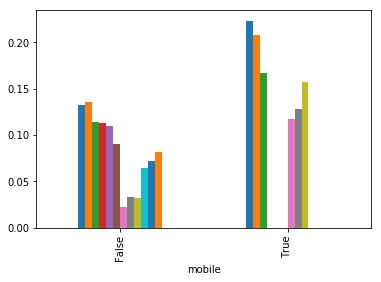

In [0]:
ct.plot(kind='bar', legend=False);

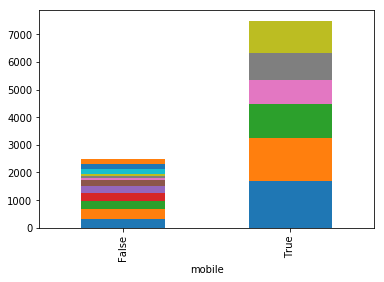

In [0]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins])

ct.plot(kind='bar', stacked=True, legend=False);

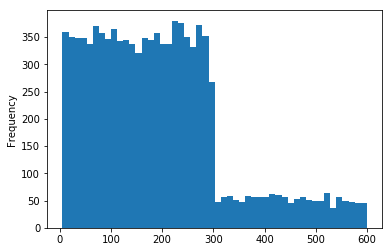

In [0]:
user_data['time_on_site'].plot.hist(bins=50);

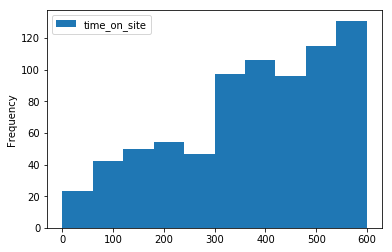

In [0]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist()

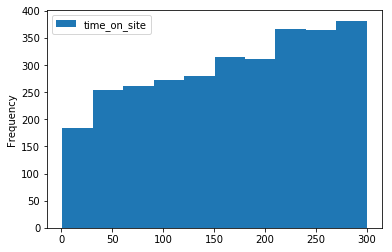

In [0]:
user_data[(user_data['mobile']==True) & (user_data['purchased']==True)].plot.hist()

In [0]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.432, 104.146]",0.317347
"(104.146, 203.265]",0.354223
"(203.265, 302.384]",0.449249
"(302.384, 401.503]",0.361991
"(401.503, 500.622]",0.394273
"(500.622, 599.74]",0.474419


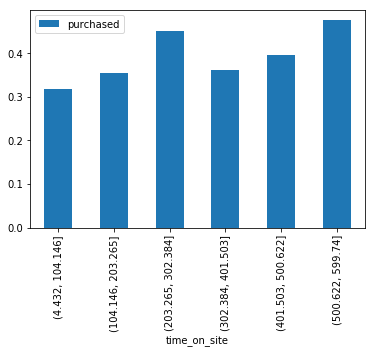

In [0]:
pt.plot.bar();

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.45, 104.184]     0.193807  0.381850  0.064815  0.275977
(104.184, 203.323]  0.169725  0.333703  0.107143  0.328767
(203.323, 302.462]  0.181193  0.284446  0.134921  0.395256
(302.462, 401.601]  0.162271  0.000000  0.222222  0.000000
(401.601, 500.74]   0.161697  0.000000  0.230159  0.000000
(500.74, 599.879]   0.131307  0.000000  0.240741  0.000000

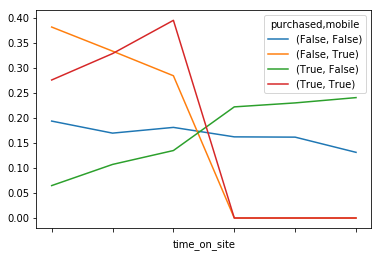

In [0]:
ct.plot();

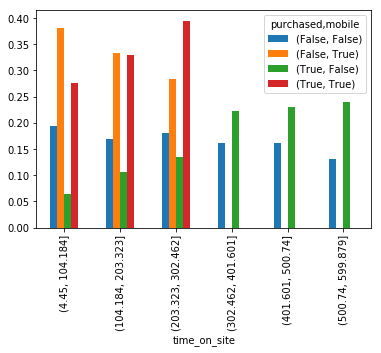

In [0]:
ct.plot(kind='bar');

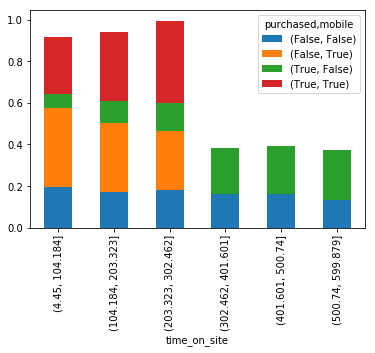

In [0]:
ct.plot(kind='bar', stacked=True);

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.45, 104.184]     0.193807  0.381850  0.064815  0.275977
(104.184, 203.323]  0.169725  0.333703  0.107143  0.328767
(203.323, 302.462]  0.181193  0.284446  0.134921  0.395256
(302.462, 401.601]  0.162271  0.000000  0.222222  0.000000
(401.601, 500.74]   0.161697  0.000000  0.230159  0.000000
(500.74, 599.879]   0.131307  0.000000  0.240741  0.000000

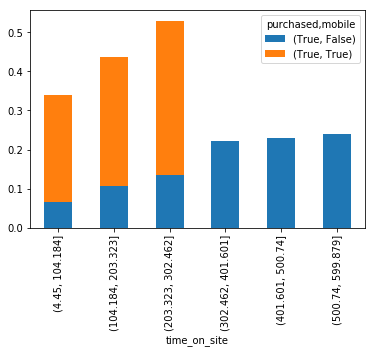

In [0]:
ct_sliced = ct.iloc[:, [2,3]]

ct_sliced.plot(kind='bar', stacked=True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [8]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
df.head(50)

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182
5,5,58,103,165
6,6,55,161,107
7,7,21,188,37
8,8,55,216,79
9,9,50,127,267


In [9]:
# Let's do a quick count.
df.count()

Unnamed: 0       1200
age              1200
weight           1200
exercise_time    1200
dtype: int64

In [10]:
# See if there's any Null values
df.isna().sum()


Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

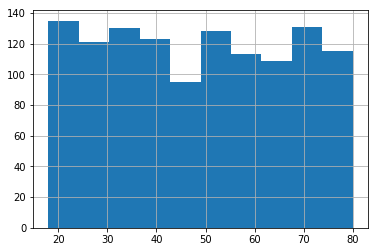

In [11]:
# First attempt - histogram
# Chose Age & Weight first. 

df.age.hist(bins=10);

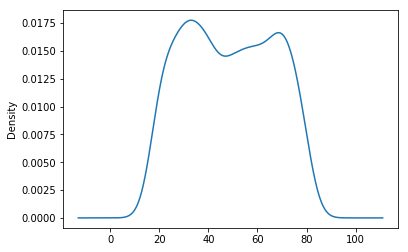

In [12]:
# Now we try Density for age

df.age.plot.density();

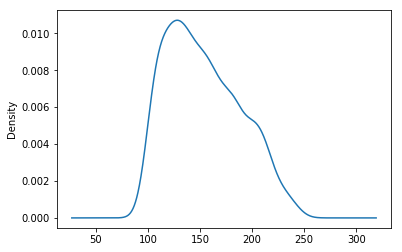

In [18]:
# Density for weight
df.weight.plot.density();

In [19]:
# Okay, now we move on to NamedTuple's.

weight_exercise = namedtuple('weight_exercise',['age', 'weight', 'exercise_time'])

example_person = weight_exercise(20, 120, 120)
print(example_person)

weight_exercise(age=20, weight=120, exercise_time=120)


In [20]:
# Use pd crosstab to see what's going on between exercising and weight.
pd.crosstab(df['exercise_time'], df['weight'])


weight,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,233,234,236,237,238,239,240,241,242,244,246
exercise_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [21]:
# we create bins by age to narrow the view a bit.  

age_bins = pd.cut(df['age'], 4)
pd.crosstab(df['weight'], age_bins)


age,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
weight,,,,
100,2,3,5,5
101,4,4,2,0
102,5,4,2,2
103,1,3,2,2
104,2,4,0,3
105,3,3,4,0
106,4,2,0,2
107,1,5,5,0
108,6,6,2,5


In [22]:
pd.crosstab(df['weight'], age_bins, normalize='columns')

age,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
weight,,,,
100,0.006231,0.009836,0.018116,0.016779
101,0.012461,0.013115,0.007246,0.000000
102,0.015576,0.013115,0.007246,0.006711
103,0.003115,0.009836,0.007246,0.006711
104,0.006231,0.013115,0.000000,0.010067
105,0.009346,0.009836,0.014493,0.000000
106,0.012461,0.006557,0.000000,0.006711
107,0.003115,0.016393,0.018116,0.000000
108,0.018692,0.019672,0.007246,0.016779


In [23]:
# Let's create weight bins, to shorten the rows.  We go back to index, and not normalized figures.
weight_bins = pd.cut(df['weight'], 4)
pd.crosstab(weight_bins, age_bins)

age,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
weight,,,,
"(99.854, 136.5]",125,135,108,86
"(136.5, 173.0]",123,93,85,96
"(173.0, 209.5]",52,60,63,78
"(209.5, 246.0]",21,17,20,38


In [24]:
# Let's see if the binned variables of age and weight make any sense.
w_age = pd.pivot_table(df, values='weight', index=age_bins)
w_age

,weight
age,
"(17.938, 33.5]",149.975078
"(33.5, 49.0]",148.849180
"(49.0, 64.5]",152.945652
"(64.5, 80.0]",162.734899


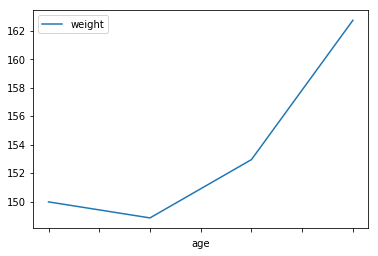

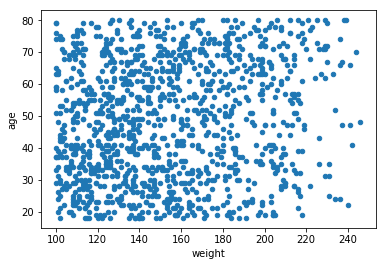

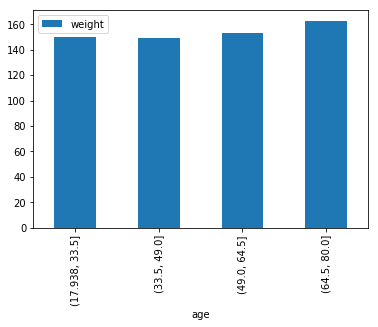

In [25]:
# Construct a bar graph.  Doesn't really say much. 
# Relationship between weight and age
w_age.plot();
df.plot.scatter('weight', 'age');
w_age.plot.bar();

In [26]:
# we bring in all three variables. Now we're including exercise time into the mix. 
# w_age_x = weight, age, and exercise_time put together.
w_age_x = pd.crosstab(age_bins, [weight_bins, df['exercise_time']], normalize='columns')
w_age_x

weight         (99.854, 136.5]                     ...  (209.5, 246.0]                    
exercise_time              2    3    4    6    7   ...             100  101  103  113  121
age                                                ...                                    
(17.938, 33.5]             0.0  0.0  0.0  0.0  1.0 ...             0.0  1.0  0.0  0.0  1.0
(33.5, 49.0]               0.0  0.0  0.0  0.0  0.0 ...             0.0  0.0  0.0  0.0  0.0
(49.0, 64.5]               1.0  1.0  0.0  0.0  0.0 ...             0.0  0.0  1.0  1.0  0.0
(64.5, 80.0]               0.0  0.0  1.0  1.0  0.0 ...             1.0  0.0  0.0  0.0  0.0

[4 rows x 648 columns]

In [27]:
# Too much data.  Let's make a bin for exercise time too.
exercise_bins = pd.cut(df['exercise_time'], 4)

w_age_x = pd.crosstab(age_bins, [weight_bins, exercise_bins])
w_age_x


weight         (99.854, 136.5]      ...       (209.5, 246.0]
exercise_time     (-0.3, 75.0]      ...        (75.0, 150.0]
age                                 ...                     
(17.938, 33.5]              18      ...                    3
(33.5, 49.0]                12      ...                    2
(49.0, 64.5]                16      ...                    7
(64.5, 80.0]                36      ...                    7

[4 rows x 13 columns]

Text(0, 0.5, 'values')

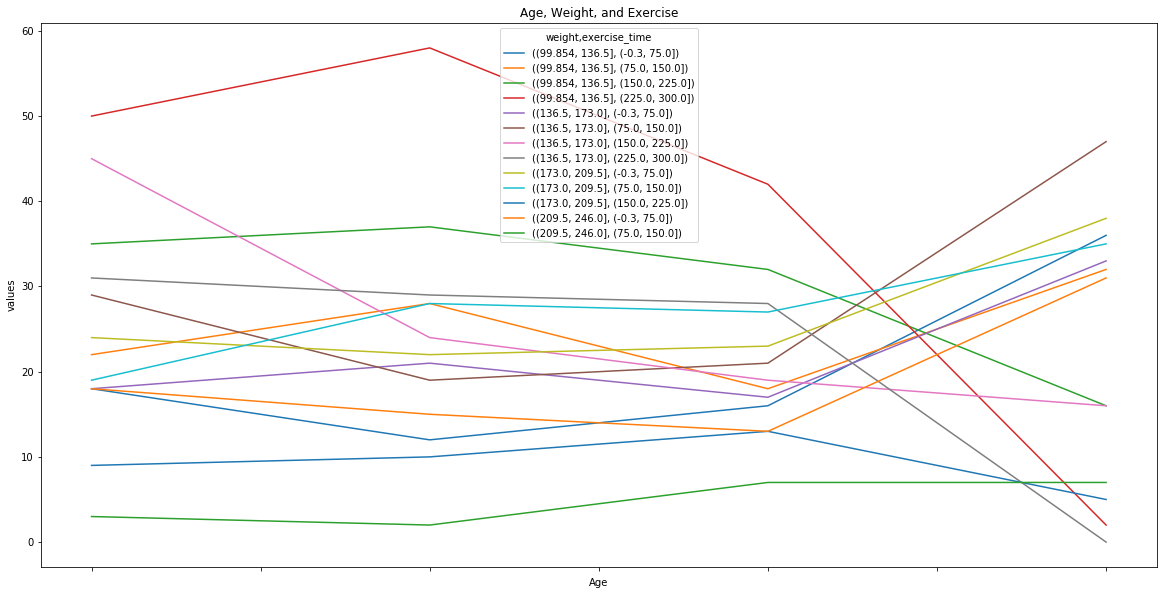

In [28]:
# Not sure what's going on here.  1) too many lines; I am sure it will make sense if we start putting titles on Y and X axes, and making charts bigger.  
# Not really sure what the values in the Y Axis represent.  
import matplotlib.pyplot as plt

w_age_x.plot(figsize=(20,10), legend=True);
plt.title('Age, Weight, and Exercise')
plt.xlabel('Age')
plt.ylabel('values')

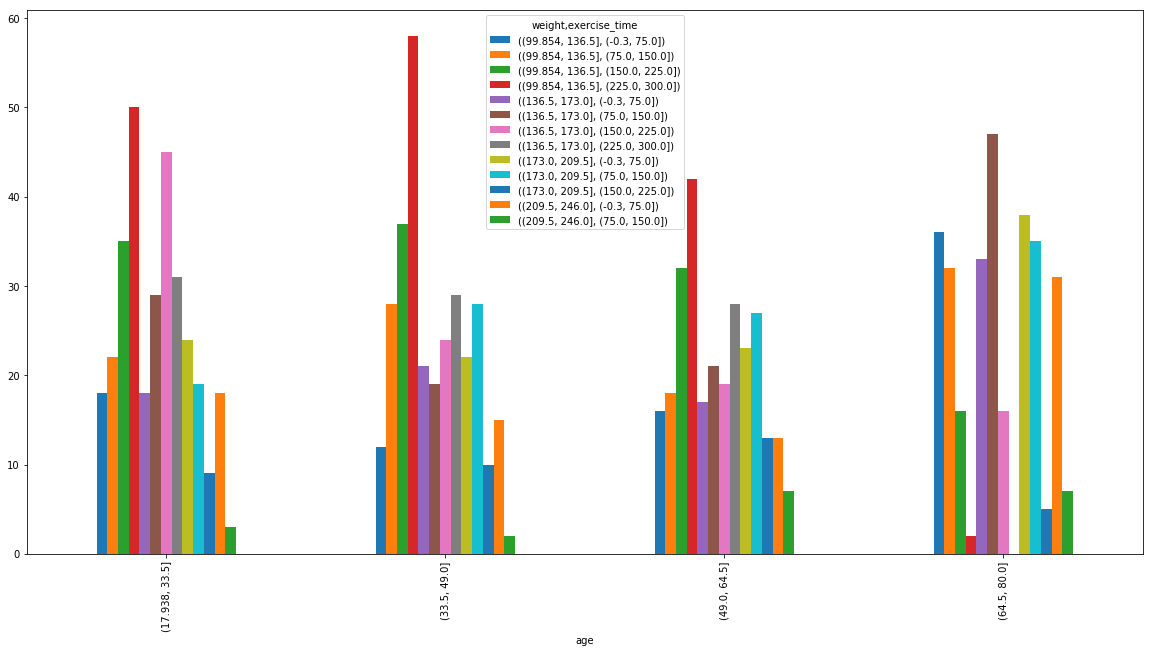

In [29]:
# Same on a bar graph -- grouped by age.  But "what is what" here?
# The legend doesn't really glean a lot of info that I can make sense of.
w_age_x.plot(figsize=(20,10), kind='bar', legend=True);

In [30]:
# Let's keep moving.  Let's backtrack and look at relationship between exercise time and weight.
# Let's look at relationship between age and exercise
wei_x = pd.pivot_table(df, values='weight', index=exercise_bins)
wei_x

,weight
exercise_time,
"(-0.3, 75.0]",172.723944
"(75.0, 150.0]",159.287791
"(150.0, 225.0]",141.095785
"(225.0, 300.0]",130.462500


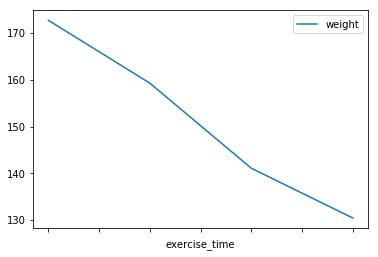

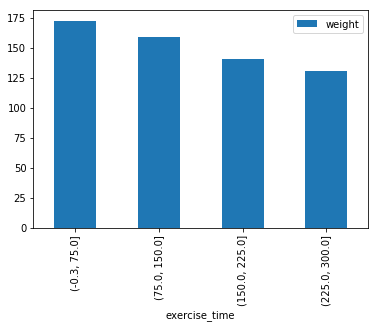

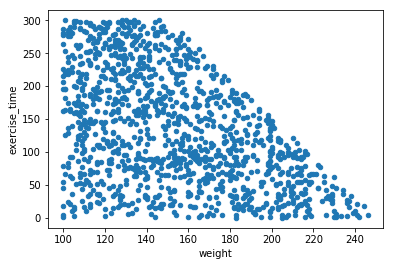

In [31]:
# Now we're getting somewhere.  As exercise time decreases, weight goes down.  
wei_x.plot();
wei_x.plot(kind='bar');
df.plot.scatter('weight', 'exercise_time');

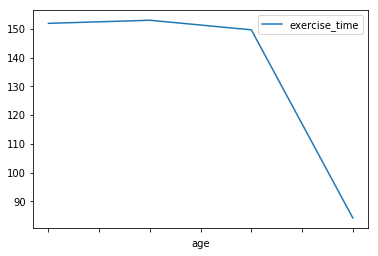

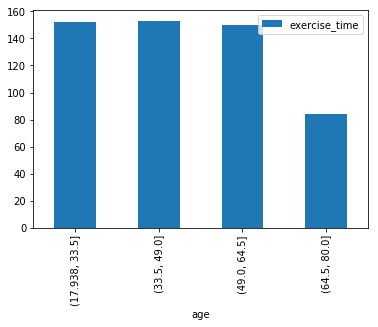

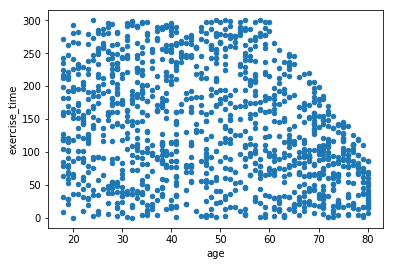

In [32]:
# Now that we've established the relationship between weight and age, and weight and exercise time, let's move on to age and exercise time.
# We can see that there's a steep drop off in age and exercise time.  
age_x = pd.pivot_table(df, values='exercise_time', index=age_bins)
age_x

age_x.plot();
age_x.plot(kind='bar');
df.plot.scatter('age', 'exercise_time');

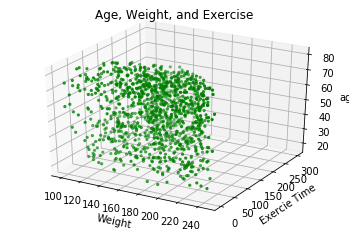

In [66]:
# UPDATE: morning of 7/11/2019.  Tried again after a good night of sleep.  How does this look?

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = df['weight']
Y = df['exercise_time']
Z = df['age']

ax.scatter(X, Y, Z, c='g', marker='.')


ax.set_title('Age, Weight, and Exercise')
ax.set_xlabel('Weight')
ax.set_ylabel('Exercie Time')
ax.set_zlabel('age')

plt.show()



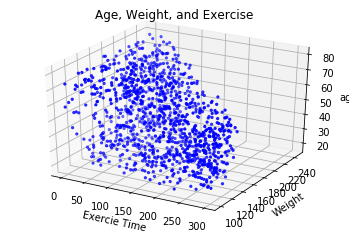

In [67]:
# Switching up the axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = df['exercise_time']
Y = df['weight']
Z = df['age']

ax.scatter(X, Y, Z, c='b', marker='.')


ax.set_title('Age, Weight, and Exercise')
ax.set_xlabel('Exercie Time')
ax.set_ylabel('Weight')
ax.set_zlabel('age')

plt.show()


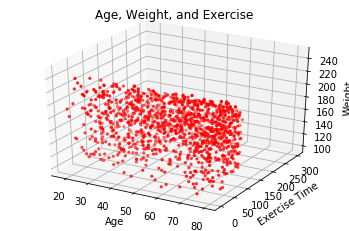

In [68]:
# Switching up the axes - last one.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = df['age']
Y = df['exercise_time']
Z = df['weight']

ax.scatter(X, Y, Z, c='r', marker='.')


ax.set_title('Age, Weight, and Exercise')
ax.set_xlabel('Age')
ax.set_ylabel('Exercise Time')
ax.set_zlabel('Weight')

plt.show()


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


**Assignment Answers**

***1. Variable Types ***

Age is a discrete, ordinal variable.  Weight is a continuous, ordinal variable.  Exercise Time is a continuous, categorical variable.
(the fact that we dealt with all whole numbers threw me off for a second)

***2. Relationships between variables:***

**Weight & Age**:  The older someone is, the more weight they gain (this should be a given -- since we start observing values as early as 17 years old; they can only gain weight over time).  That's according to the scatter plot.  When I break it down to a bar and scatterplot, the correlation seems to disappear -- and that the weight over the four age bins I've created have remained rather steady.  

**Weight & Exercise Time**: This one resembled real world numbers.  The line graph, scatter plots, and bar graphs supported the evidence that more exercise time resulted in lower observable weight on the population.

**Age & Exercise Time**: This one also makes intuitive sense.  The older someone is, the less time they spend exercising.  I separated my age sets into four bins.  After the 49-65 year old age group, exercise time dropped off dramatically.  (Question for myself: what would that data look like if we increased the bins to five or six?)

***3. Real & Spurious***

Based on the graphs alone -- I would say that "Weight & Exercise Time", and "Age & Exercise Time" are "real", while the "Weight & Age" relationship is spurious.  

All three graph types (line, scatterplot, bar) visually support each other for "Weight & Exercise" and "Age & Exercise".  While the "Weight & Age" scatterplot & bar seems to be evenly distributed, the line graph shows an increase in weight with increased age.

But I'm conflicted - becaues based on the line graph from "Weight & Age", I could also say that the data is real.

Will have to mull it over and go back to it!

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)